In [ ]:
# Load, explore and plot data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Train test split
from sklearn.model_selection import train_test_split

# Accuracy score.
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, Bidirectional, Flatten, GlobalAveragePooling1D, GlobalMaxPool1D

# Data Splitting and Pre-processing

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CSE440/train.csv')
df = df[['text', 'target',]]
df.rename(columns={'target':'label'}, inplace=True )
df.head(10)

,text,label
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
5,#RockyFire Update => California Hwy. 20 closed...,1
6,#flood #disaster Heavy rain causes flash flood...,1
7,I'm on top of the hill and I can see a fire in...,1
8,There's an emergency evacuation happening now ...,1
9,I'm afraid that the tornado is coming to our a...,1


In [ ]:
tweet = df['text'].values
y = df['label'].values
df.describe()

,label
count,7613.00000
mean,0.42966
std,0.49506
min,0.00000
25%,0.00000
50%,0.00000
75%,1.00000
max,1.00000


In [ ]:
df.groupby('label').describe().T

label                                                        0  \
text count                                                4342   
     unique                                               4315   
     top     The Prophet (peace be upon him) said 'Save you...   
     freq                                                    4   

label                                                        1  
text count                                                3271  
     unique                                               3206  
     top     11-Year-Old Boy Charged With Manslaughter of T...  
     freq                                                   10

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


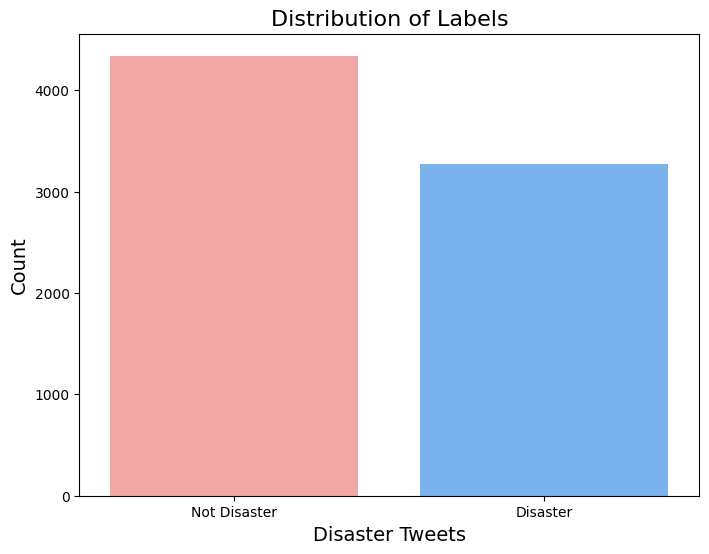

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='label', hue='label', palette=['#FF9999', '#66B2FF'], legend=False)

plt.xticks([0, 1], ['Not Disaster', 'Disaster'])

plt.xlabel('Disaster Tweets', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Labels', fontsize=16)

plt.show()


**Train Test Split**

In [ ]:
tweet_train, tweet_test, y_train, y_test = train_test_split(tweet, y, test_size=0.1, random_state=1000)

**Tokenization**

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweet_train)

X_train = tokenizer.texts_to_sequences(tweet_train)
X_test = tokenizer.texts_to_sequences(tweet_test)

vocab_size = len(tokenizer.word_index) + 1

print(tweet_test[2])
print(X_train[2])
print(vocab_size)
maxlen = max(len(seq) for seq in X_train)
maxlen_test = max(len(seq) for seq in X_test)
print(maxlen, maxlen_test)


US wont upgrade its infrastructure? http://t.co/NGEHhG9YGa' it a bad situation and its going to get ugly very quickly #USA #sustainability
[435, 1781, 111, 56, 321, 10, 5, 305, 6475, 404, 4317, 2702, 10, 6476, 618, 822]
21084
33 31


**Padding**

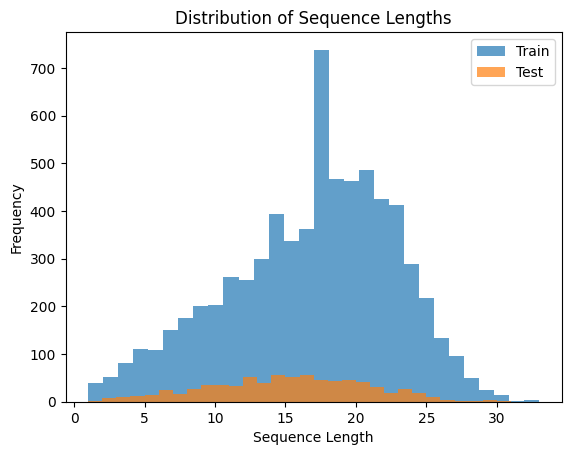

In [ ]:
import matplotlib.pyplot as plt

# Calculate lengths of all sequences
sequence_lengths_train = [len(seq) for seq in X_train]
sequence_lengths_test = [len(seq) for seq in X_test]

# Plot histogram
plt.hist(sequence_lengths_train, bins=30, alpha=0.7, label='Train')
plt.hist(sequence_lengths_test, bins=30, alpha=0.7, label='Test')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.legend(loc='upper right')
plt.show()


In [ ]:
# Training
print(maxlen)
# maxlen = 128
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
# Testing
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])
print('Shape of training tensor: ', X_train.shape)
print('Shape of testing tensor: ', X_test.shape)

33
[ 192  119  134  402  434   16  862    8  863  403   46  192  119  134
  402   45   60  434   16  862   66    4  199 1614    0    0    0    0
    0    0    0    0    0]
Shape of training tensor:  (6851, 33)
Shape of testing tensor:  (762, 33)


**Embedding with GloVe**
*Using matrices of 100 dimensions for each word and storing the embedding matrix extracted from GLoVe in a variable called embedding_matrix*

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix  = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix



In [ ]:
embedding_dim = 100
embedding_matrix = create_embedding_matrix('/content/drive/MyDrive/CSE440/glove.6B.100d.txt', tokenizer.word_index, embedding_dim)

print(embedding_matrix.shape)

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size
# covers 56.2% of the vocab size.

(21084, 100)


0.562986150635553

# Creating Multiple Model

**Model-1 : Shallow RNN Model with an embedding layer, a dense layer with 10 hidden units and a output layer.**

In [ ]:
# Dimensions
print(X_train.shape)        # (6851, 33)
print(embedding_matrix.shape)  # (21084, 100)
print(vocab_size)         # 21084
print(maxlen)         # 33

# Model (explicit input = input_shape)
model0 = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=maxlen,
              input_shape=(maxlen,)),
    GlobalMaxPool1D(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

#Compilation
model0.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

#Summary
model0.summary()

(6851, 33)
(21084, 100)
21084
33


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 33, 100)             │       2,108,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 100)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           3,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,111,665 (8.06 MB)

 Trainable params: 2,111,665 (8.06 MB)

 Non-trainable params: 0 (0.00 B)

**Model-2: Introduction of gated recurrence relation to the shallow RNN model with an embedding layer, a unidirectional LSTM layer with 10 hidden units and an output layer.**

In [ ]:
# Defined Parameters:
n_lstm = 32
drop_rate = 0.1

# Model
model1 = Sequential([
    Embedding(vocab_size, embedding_dim,
              weights=[embedding_matrix],
              input_length=maxlen,
              input_shape=(maxlen,)),
    LSTM(n_lstm, return_sequences=False),
    Dropout(drop_rate),
    Dense(1, activation='sigmoid')
])

#Compilation
model1.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])
#Summary
model1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 33, 100)             │       2,108,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          17,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,125,457 (8.11 MB)

 Trainable params: 2,125,457 (8.11 MB)

 Non-trainable params: 0 (0.00 B)

**Model-3:  Changing the uni-directional LSTM layer with a bi-directional LSTM layer.**

In [ ]:
# Defined Parameters:
n_lstm = 32
drop_rate = 0.1

# Model
model2 = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=maxlen,
              input_shape=(maxlen,)),
    Bidirectional(LSTM(n_lstm, return_sequences=False)),
    Dropout(drop_rate),
    Dense(1, activation='sigmoid')
])

# Model Compilation
model2.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy',]) #'Precision', 'Recall'

# Model Summary
model2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 33, 100)             │       2,108,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 64)                  │          34,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,142,513 (8.17 MB)

 Trainable params: 2,142,513 (8.17 MB)

 Non-trainable params: 0 (0.00 B)

# Training, Testing and Visual Representation of output.

In [ ]:
from keras.backend import clear_session
clear_session()

**Graph general code**

In [ ]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot training & validation accuracy values
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='lower right')

    # Plot training & validation loss values
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

def plot_metrics_comparison(train_metrics, test_metrics):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, train_metrics, width, label='Train')
    rects2 = ax.bar(x + width/2, test_metrics, width, label='Test')

    ax.set_ylabel('Scores')
    ax.set_title('Training vs Testing Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()
    plt.show()

# **Model-01**

In [ ]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train
basic_rnn = model0.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluation on training data
train_loss, train_accuracy = model0.evaluate(X_train, y_train, verbose=0)
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluation on testing data
test_loss, test_accuracy = model0.evaluate(X_test, y_test, verbose=0)
print(f"Testing Loss: {test_loss:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Predictions
y_train_pred_prob = model0.predict(X_train)
y_test_pred_prob = model0.predict(X_test)

y_train_pred = (y_train_pred_prob > 0.5).astype(int)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Metrics Calc for training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)

print("\nTraining Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")

# Metrics Calc for testing data
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

print("\nTesting Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

Epoch 1/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6270 - loss: 0.6551 - val_accuracy: 0.7624 - val_loss: 0.5123
Epoch 2/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7782 - loss: 0.4837 - val_accuracy: 0.8017 - val_loss: 0.4426
Epoch 3/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8309 - loss: 0.3952 - val_accuracy: 0.8265 - val_loss: 0.4180
Epoch 4/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8616 - loss: 0.3379 - val_accuracy: 0.8280 - val_loss: 0.4078
Epoch 5/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8926 - loss: 0.2864 - val_accuracy: 0.8309 - val_loss: 0.4577
Epoch 6/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9130 - loss: 0.2359 - val_accuracy: 0.8265 - val_loss: 0.4364
Epoch 7/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9404 - loss: 0.1734 - val_accuracy: 0.8222 - val_loss: 0.4434
Training Loss: 0.2928
Training Accuracy: 0.8866
Testing Loss: 0.4370
Testing Accuracy: 0.7979
215/215 ━━

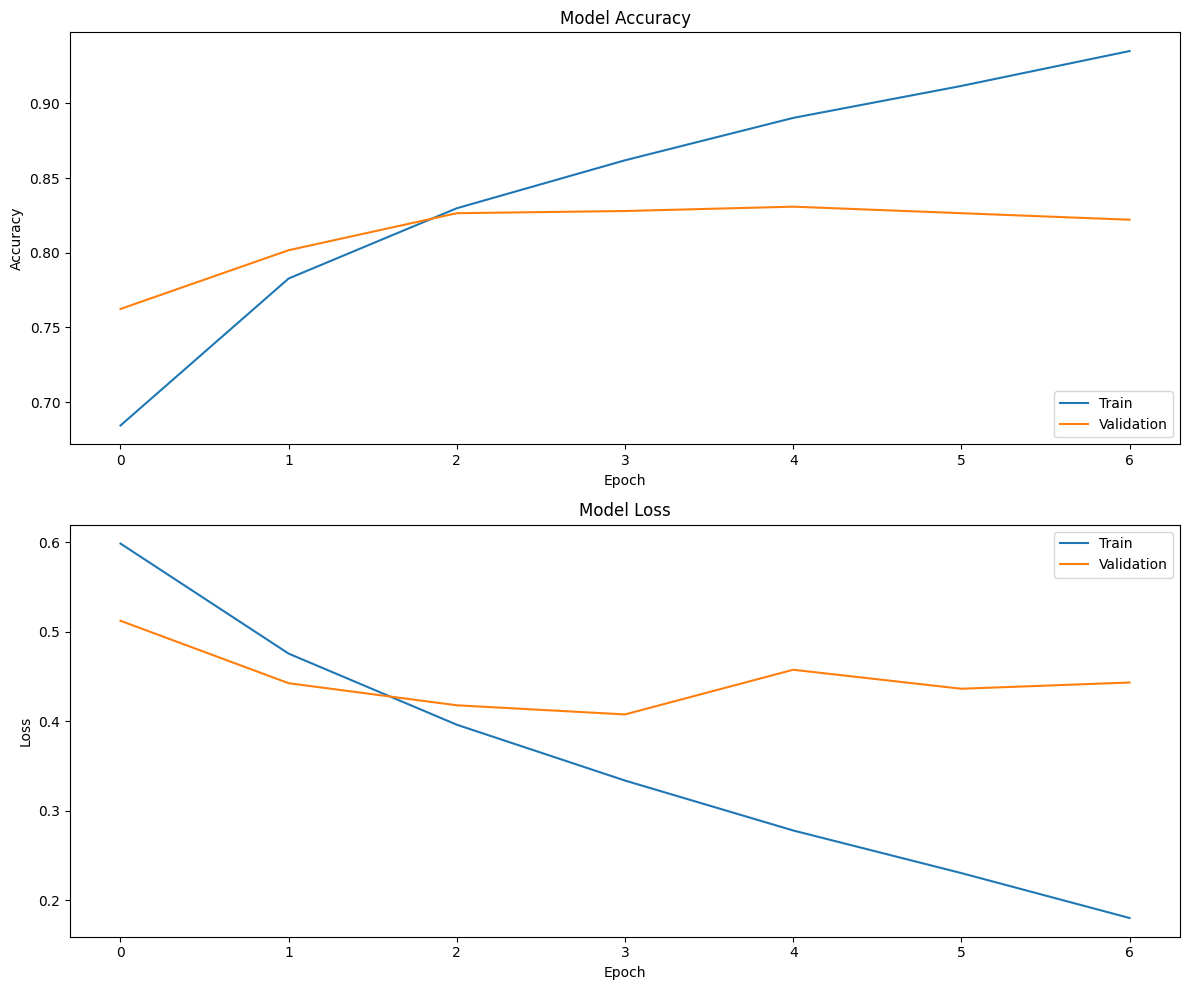

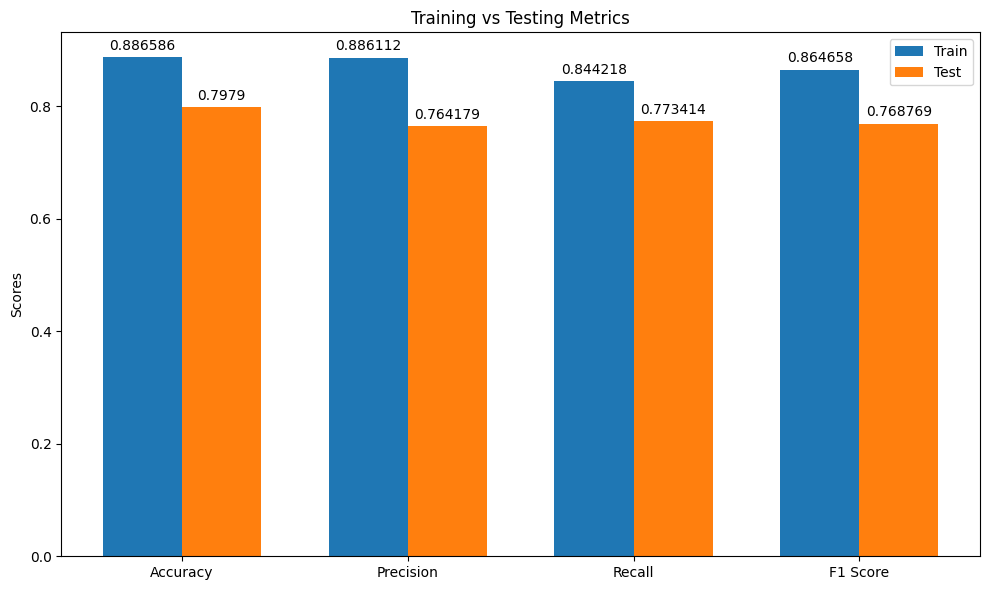

Final Training Loss: 0.2928
Final Testing Loss: 0.4370


In [ ]:
# Plot training history
plot_training_history(basic_rnn)

# Prepare metrics for comparison plot
train_metrics = [train_accuracy, train_precision, train_recall, train_f1]
test_metrics = [test_accuracy, test_precision, test_recall, test_f1]

# Plot metrics comparison
plot_metrics_comparison(train_metrics, test_metrics)

# Print final loss values
print(f"Final Training Loss: {train_loss:.4f}")
print(f"Final Testing Loss: {test_loss:.4f}")

# **Model-02**

In [ ]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train
uni_LSTM = model1.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluation on training data
train_loss, train_accuracy = model1.evaluate(X_train, y_train, verbose=0)
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluation on testing data
test_loss, test_accuracy = model1.evaluate(X_test, y_test, verbose=0)
print(f"Testing Loss: {test_loss:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Predictions
y_train_pred_prob = model1.predict(X_train)
y_test_pred_prob = model1.predict(X_test)

y_train_pred = (y_train_pred_prob > 0.5).astype(int)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Metrics Calc for training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)

print("\nTraining Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")

# Metrics Calc for testing data
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

print("\nTesting Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

Epoch 1/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8731 - loss: 0.3256 - val_accuracy: 0.8455 - val_loss: 0.3949
Epoch 2/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9137 - loss: 0.2270 - val_accuracy: 0.8455 - val_loss: 0.4172
Epoch 3/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9511 - loss: 0.1517 - val_accuracy: 0.7959 - val_loss: 0.4627
Epoch 4/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9743 - loss: 0.1007 - val_accuracy: 0.8222 - val_loss: 0.5118
Training Loss: 0.2394
Training Accuracy: 0.9118
Testing Loss: 0.4365
Testing Accuracy: 0.8123
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Training Metrics:
Accuracy: 0.9118
Precision: 0.9241
Recall: 0.8656
F1 Score: 0.8939

Testing Metrics:
Accuracy: 0.8123
Precision: 0.8154
Recall: 0.7341
F1 Score: 0.7727


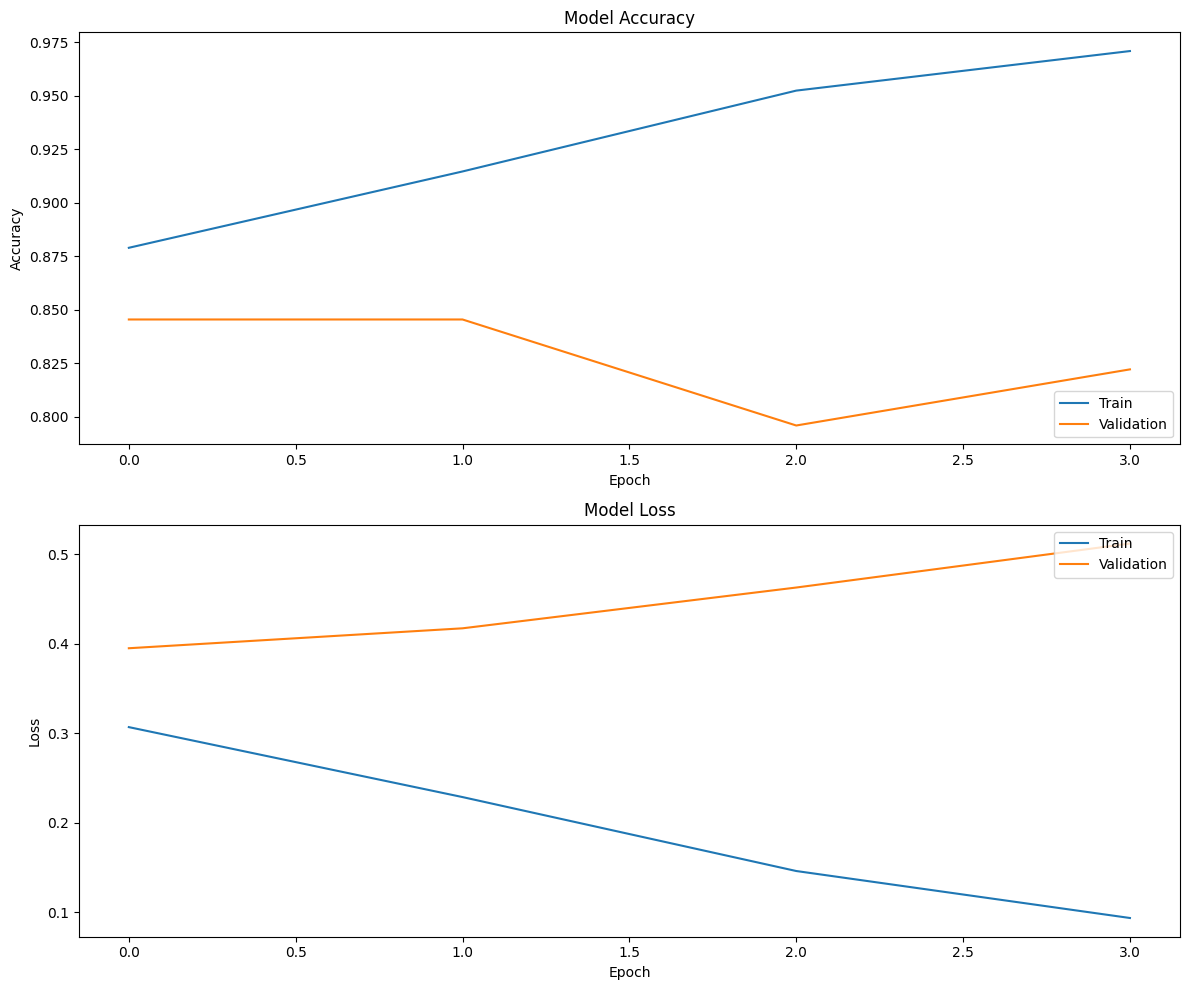

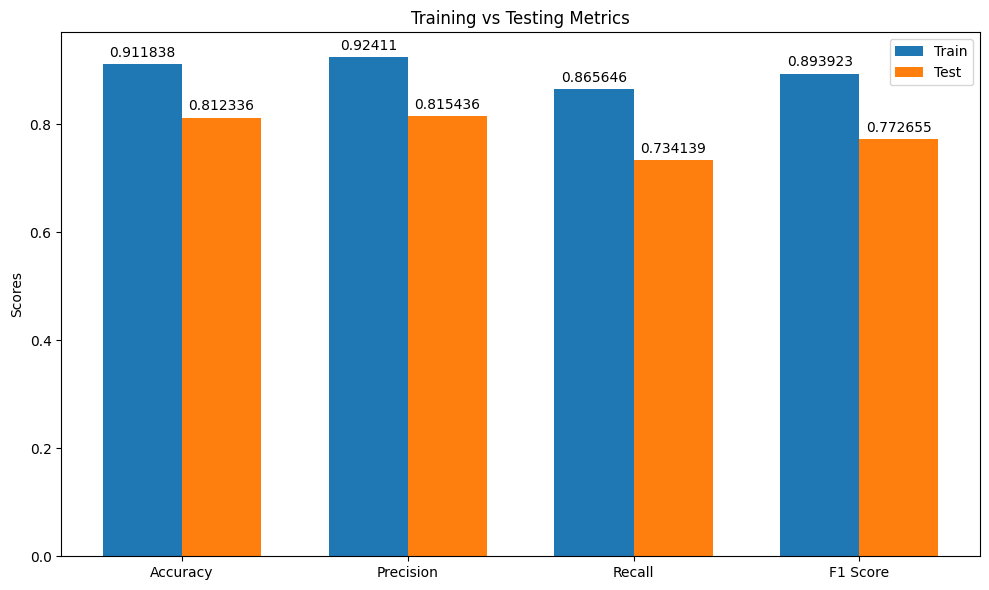

Final Training Loss: 0.2394
Final Testing Loss: 0.4365


In [ ]:
# Plot training history
plot_training_history(uni_LSTM)

# Prepare metrics for comparison plot
train_metrics = [train_accuracy, train_precision, train_recall, train_f1]
test_metrics = [test_accuracy, test_precision, test_recall, test_f1]

# Plot metrics comparison
plot_metrics_comparison(train_metrics, test_metrics)

# Print final loss values
print(f"Final Training Loss: {train_loss:.4f}")
print(f"Final Testing Loss: {test_loss:.4f}")

# **Model-03**

In [ ]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train
bi_LSTM = model2.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluation on training data
train_loss, train_accuracy = model2.evaluate(X_train, y_train, verbose=0)
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluation on testing data
test_loss, test_accuracy = model2.evaluate(X_test, y_test, verbose=0)
print(f"Testing Loss: {test_loss:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Predictions
y_train_pred_prob = model2.predict(X_train)
y_test_pred_prob = model2.predict(X_test)

y_train_pred = (y_train_pred_prob > 0.5).astype(int)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Metrics Calc for training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)

print("\nTraining Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")

# Metrics Calc for testing data
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

print("\nTesting Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

Epoch 1/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8943 - loss: 0.2794 - val_accuracy: 0.8382 - val_loss: 0.3780
Epoch 2/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9323 - loss: 0.1899 - val_accuracy: 0.8455 - val_loss: 0.4080
Epoch 3/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9594 - loss: 0.1095 - val_accuracy: 0.8017 - val_loss: 0.5922
Epoch 4/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9821 - loss: 0.0551 - val_accuracy: 0.8280 - val_loss: 0.5410
Training Loss: 0.2121
Training Accuracy: 0.9238
Testing Loss: 0.4185
Testing Accuracy: 0.8163
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Training Metrics:
Accuracy: 0.9238
Precision: 0.9287
Recall: 0.8908
F1 Score: 0.9094

Testing Metrics:
Accuracy: 0.8163
Precision: 0.7957
Recall: 0.7764
F1 Score: 0.7859


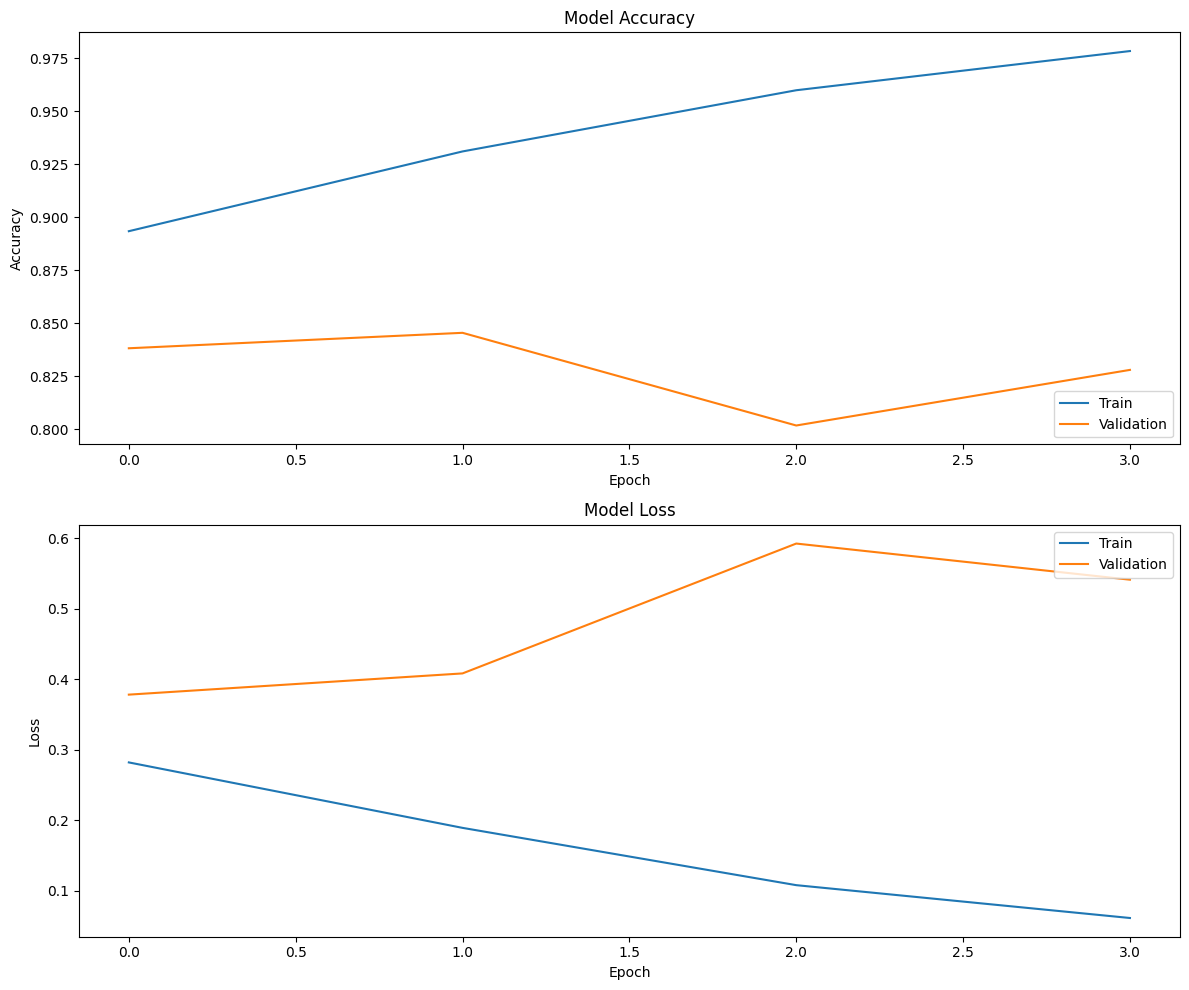

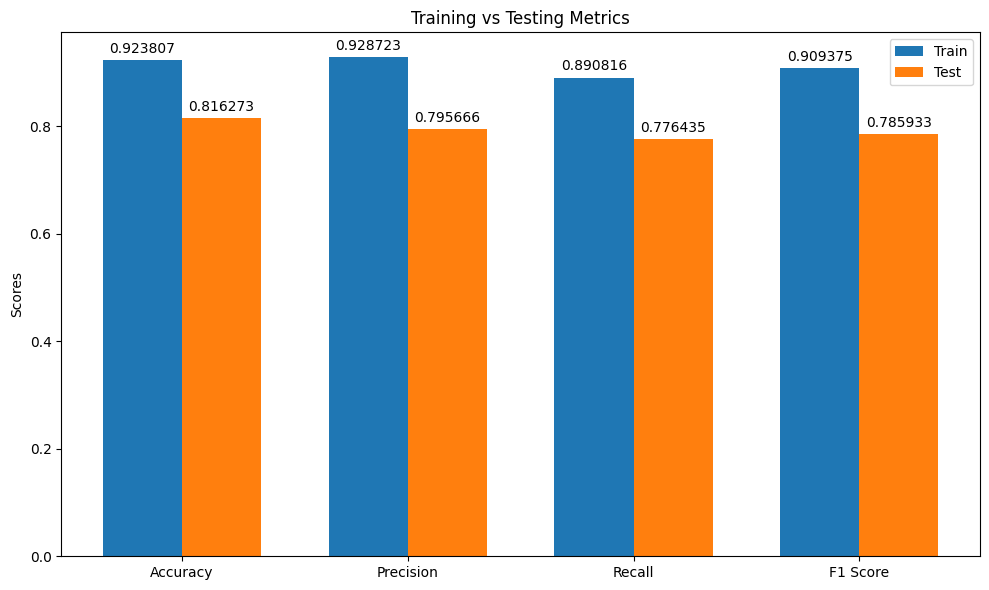

Final Training Loss: 0.2121
Final Testing Loss: 0.4185


In [ ]:
# Plot training history
plot_training_history(bi_LSTM)

# Prepare metrics for comparison plot
train_metrics = [train_accuracy, train_precision, train_recall, train_f1]
test_metrics = [test_accuracy, test_precision, test_recall, test_f1]

# Plot metrics comparison
plot_metrics_comparison(train_metrics, test_metrics)

# Print final loss values
print(f"Final Training Loss: {train_loss:.4f}")
print(f"Final Testing Loss: {test_loss:.4f}")

Hardcoded - [Picked up the template from the internet]

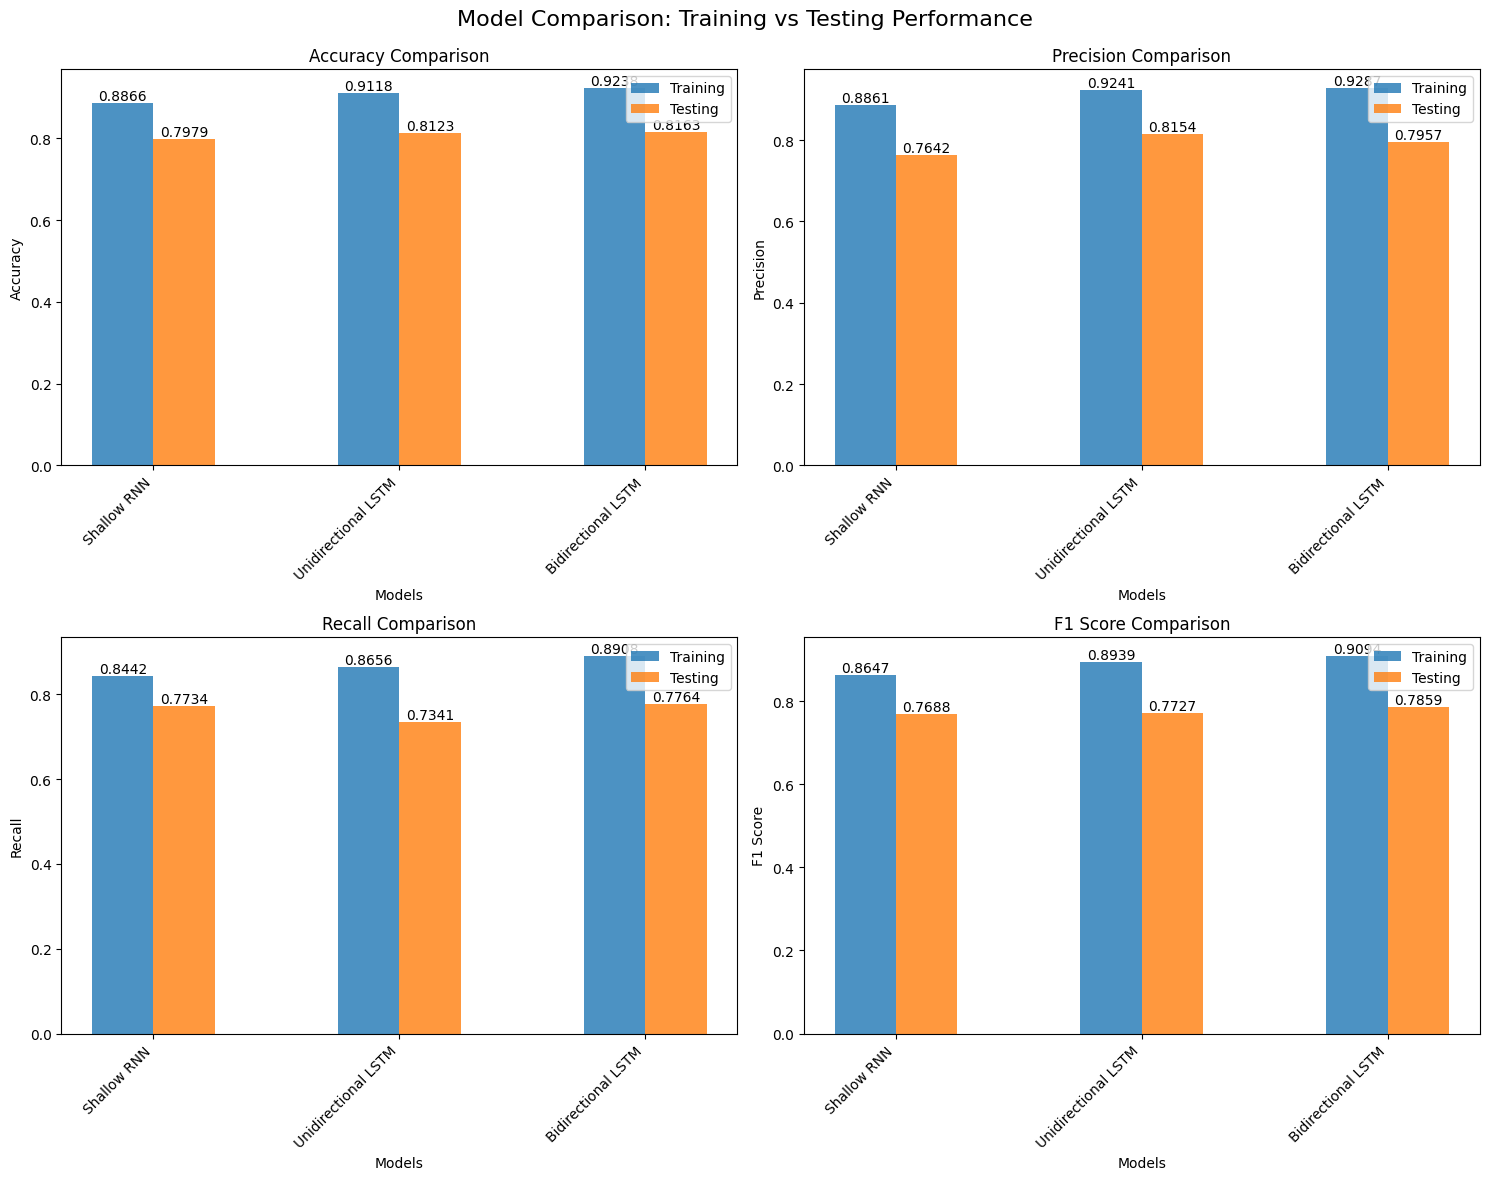

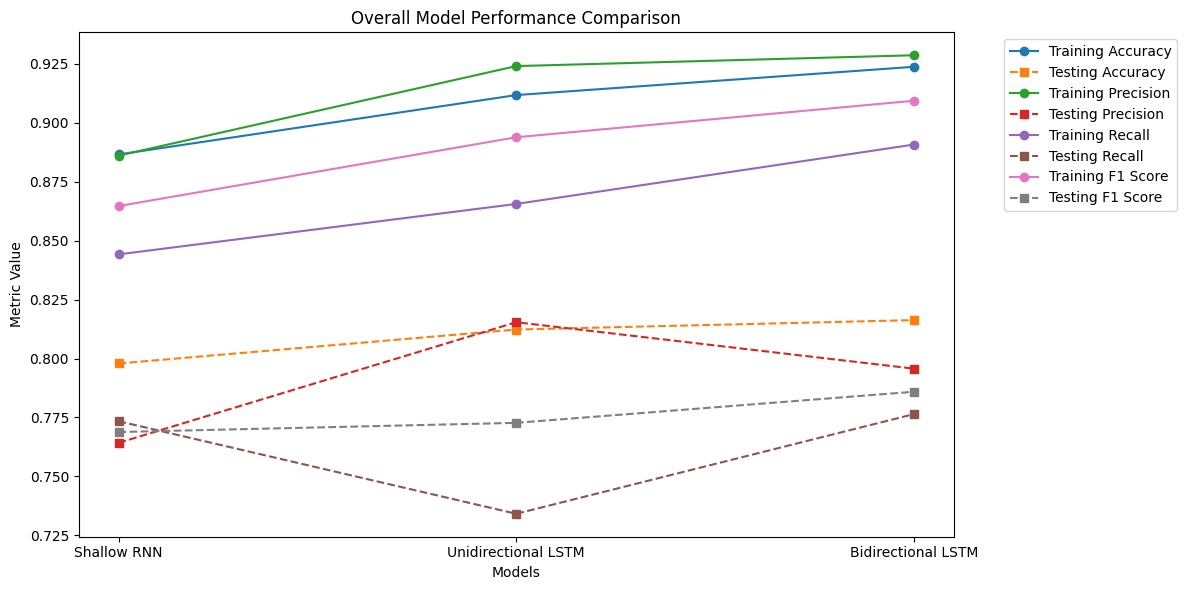

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Shallow RNN', 'Unidirectional LSTM', 'Bidirectional LSTM']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

training_data = np.array([
    [0.8866, 0.8861, 0.8442, 0.8647],
    [0.9118, 0.9241, 0.8656, 0.8939],
    [0.9238, 0.9287, 0.8908, 0.9094]
])

testing_data = np.array([
    [0.7979, 0.7642, 0.7734, 0.7688],
    [0.8123, 0.8154, 0.7341, 0.7727],
    [0.8163, 0.7957, 0.7764, 0.7859]
])

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Comparison: Training vs Testing Performance', fontsize=16)

bar_width = 0.25
index = np.arange(len(models))

for i, metric in enumerate(metrics):
    ax = axs[i // 2, i % 2]

    ax.bar(index, training_data[:, i], bar_width, label='Training', alpha=0.8)
    ax.bar(index + bar_width, testing_data[:, i], bar_width, label='Testing', alpha=0.8)

    ax.set_xlabel('Models')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend()

    # Add value labels
    for j, v in enumerate(training_data[:, i]):
        ax.text(j, v, f'{v:.4f}', ha='center', va='bottom')
    for j, v in enumerate(testing_data[:, i]):
        ax.text(j + bar_width, v, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

# Line plot for overall comparison
plt.figure(figsize=(12, 6))

for i, metric in enumerate(metrics):
    plt.plot(models, training_data[:, i], marker='o', label=f'Training {metric}')
    plt.plot(models, testing_data[:, i], marker='s', linestyle='--', label=f'Testing {metric}')

plt.xlabel('Models')
plt.ylabel('Metric Value')
plt.title('Overall Model Performance Comparison')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
clear_session()